In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits import mplot3d

%matplotlib inline

In [2]:
Mo_ka = (275, 17444.3)
Mo_kb = (309, 19608.3)
W_ka2 = (913, 57981.7)
W_ka1 = (934, 59318.24)
W_kb = (1058, 67244.3)

In [3]:
#Make a dataframe from the sample directory. Good to visualize data. You should 
#feed this dataframe to another function that will make an array of objects

def gen_spec_df(folder_dir, meta_dic):
    
    #initialize a df of the CSV sample/scan info.
    #This should probably be something I iron out with path (it'd be a '\' on PC) but it's fine for now
    raw_df = pd.read_csv(folder_dir + "/" + meta_dic)
    
    #get the hdf filename for every file in the directory
    files = []
    for x in os.listdir(folder_dir):
        if x.endswith(".hdf5"):
            files.append(x)
    
    #Add a column for filename in meta_df that is the same length of the meta_df
    edxname = [''] * len(raw_df.index)
    raw_df['FileName'] = edxname
    
    #Find each file in the meta_df by comparing scan number. Add file name 
    for y in range(len(files)):
        hdf_file = h5py.File(directory + files[y], 'r')
        for z in range(len(raw_df.index)):
            if raw_df['ScanNum'].values[z] == hdf_file.attrs['Scan Number']:
                raw_df['FileName'].values[z] = directory+files[y]
    
    #Add a column for EDX data arrays
    edxd = [''] * len(raw_df.index)
    raw_df['Spectra'] = edxd
    raw_df['Position'] = edxd
    
    #Scan through filenames and add position and spectra data arrays to df
    #If there's none, set those values equal to some string or warning
    for h in range(len(raw_df.index)):
        datahdf = h5py.File(raw_df['FileName'].values[h], 'r')
        positionflag = 'No Position Data (uh oh)'
        spectraflag = 'No Spectra Data (uh oh)'
        with h5py.File(raw_df['FileName'].values[h], 'r') as f:
            for x in range(len(f.keys())):
                if list(f.keys())[x] == '7bmb1:aero:m2.VAL':
                    raw_df['Position'].values[h] = f['7bmb1:aero:m2.VAL'][...]
                    positionflag = 'yep'
                if list(f.keys())[x] == 'dxpMercury:mca1.VAL':
                    raw_df['Spectra'].values[h] = f['dxpMercury:mca1.VAL'][...]
                    spectraflag = 'yep'
        if positionflag != 'yep':
            raw_df['Position'].values[h] = []
        if spectraflag != 'yep':
            raw_df['Spectra'].values[h] = []

    return raw_df

In [4]:
directory = '/Users/anthonygironda/Documents/MDA_Scans_Seidler/'
meta = '7bmb1_10.19.22_EDXindex.csv'

sample_df = gen_spec_df(directory, meta)
sample_df.tail()
# display(sample_df)

,ScanNum,FullName,pH,Days,Temperature,Atmosphere,SteelFiber,Aborted,Notes,Start (mm),End (mm),Step Size (mm),Slit Entrance (um),Scan Time,Rotation Speed (deg/s),FileName,Spectra,Position
38,1104,High pH BL 60C 4d,High,4.0,60.0,100% CO2,False,False,NaN,13.0,6.0,0.25,100.0,20.0,18.0,/Users/anthonygironda/Documents/MDA_Scans_Seid...,"[[0.0, 1027.0, 1265.0, 1379.0, 1566.0, 1662.0,...","[-13.0, -12.75, -12.5, -12.25, -12.0, -11.75, ..."
39,1105,High pH BL 60C 2d,High,2.0,60.0,100% CO2,False,False,NaN,13.0,6.0,0.25,100.0,20.0,18.0,/Users/anthonygironda/Documents/MDA_Scans_Seid...,"[[0.0, 1079.0, 1226.0, 1443.0, 1651.0, 1690.0,...","[-13.0, -12.75, -12.5, -12.25, -12.0, -11.75, ..."
40,1106,High pH BL 25C 14d,High,14.0,25.0,100% CO2,False,False,NaN,13.0,6.0,0.25,100.0,20.0,18.0,/Users/anthonygironda/Documents/MDA_Scans_Seid...,"[[0.0, 1132.0, 1313.0, 1520.0, 1723.0, 1748.0,...","[-13.0, -12.75, -12.5, -12.25, -12.0, -11.75, ..."
41,1107,High pH BL 25C 4d,High,4.0,25.0,100% CO2,False,False,NaN,13.0,6.0,0.25,100.0,20.0,18.0,/Users/anthonygironda/Documents/MDA_Scans_Seid...,"[[0.0, 1085.0, 1252.0, 1458.0, 1690.0, 1811.0,...","[-13.0, -12.75, -12.5, -12.25, -12.0, -11.75, ..."
42,1108,High pH BL Ref,High,0.0,25.0,100% CO2,False,False,NaN,13.0,6.0,0.25,100.0,20.0,18.0,/Users/anthonygironda/Documents/MDA_Scans_Seid...,"[[0.0, 1058.0, 1208.0, 1470.0, 1605.0, 1803.0,...","[-13.0, -12.75, -12.5, -12.25, -12.0, -11.75, ..."


In [5]:
class scan:
    
    cal_feat = [Mo_ka, Mo_kb, W_ka2, W_ka1, W_kb]
    cal_fit_order = 1
    
    def __init__(self, spectra, position_from_center):
        self.spectra = spectra
        self.beam_position = position_from_center
        self.cal_fit_order = 1

    def set_cal_features(self, list_of_tup): self.cal_feat = list_of_tup
    def set_cal_order(self, n): self.cal_fit_order = n
    
    def get_cal_features(self): return (self.cal_feat)
    def get_bins(self): return (list(range(len(self.spectra))))
    def get_position(self): return self.beam_position
    def get_spectrum(self): return self.spectra
    def get_energy(self): return poly_function(self.get_bins(), np.polyfit([i[0] for i in self.cal_feat], [i[1] for i in self.cal_feat], self.cal_fit_order))
    def conv_bins_to_energy(self, bin_array): return poly_function(bin_array, np.polyfit([i[0] for i in xy], [i[1] for i in xy], degree))
        
    
    def quick_plot(self, energy_bool):
        #Plot by energy [keV]
        if energy_bool == True:
            spec_data = self.spectra
            x_data_kev = self.get_energy()
            fig, ax = plt.subplots(figsize = (10,6))
            ax.plot(x_data_kev, spec_data)
            ax.set_xlabel('Energy [keV]')
            ax.set_ylabel('Counts')
            ax.grid(True)
        #Plot by bins
        else:
            spec_data = self.spectra
            x_dat = self.get_bins()
            fig, ax = plt.subplots(figsize = (10,6))
            ax.plot(x_dat, spec_data, linewidth=2.0)
            ax.set_xlabel('Bins')
            ax.set_ylabel('Counts')
            ax.grid(True)
        return (fig, ax)
    
    def quick_scatter(self, energy_bool):
        #Plot by energy [keV]
        if energy_bool == True:
            spec_data = self.spectra
            x_data_kev = self.get_energy()
            fig, ax = plt.subplots(figsize = (10,6))
            ax.scatter(x_data_kev, spec_data)
            ax.set_xlabel('Energy [keV]')
            ax.set_ylabel('Counts')
            ax.grid(True)
        #Plot by bins
        else:
            spec_data = self.spectra
            x_dat = self.get_bins()
            fig, ax = plt.subplots(figsize = (10,6))
            ax.scatter(x_dat, spec_data)
            ax.set_xlabel('Bins')
            ax.set_ylabel('Counts')
            ax.grid(True)
        return (fig, ax)

In [56]:
#When bool_pos_given_as_index is True, the pos instantiation variable is an index. Otherwise, when false,
#the pos instantiation variable is an actual position value, like -13.0 or 6.75. It also catches
#an edge case when the position array is empty, such as the calibration scan 1069. Things may behave funny when
#position arrays end in duplicates of 0s or any duplicates in general

#There's potentially a problem for if the spectra passed to the scan is a list or a numpy array, be aware.
def scan_instant_helper(df, scannum, pos, bool_pos_given_as_index):
    errorflag = True
    pos_i = None
    scan_index = (df[df['ScanNum']==scannum].index.values)[0]
    pos_array = df['Position'][scan_index]
    
    #edge case checker, if the position array of a given scan number is empty
    if ((pos == 0) and len(pos_array)==0):
        spectra_set = df['Spectra'][scan_index]
        spectra = spectra_set
        return scan(spectra, None)

    #If the bool is given as true, treat the pos variable like an index and not a value
    #Check first that the pos as an index is within the range of the scan's position array
    if bool_pos_given_as_index == True:
        if pos > (len(pos_array)-1): 
            return print('ERROR: Index is out of range of position array')
        else:
            pos_i = pos
            pos_value = abs(df['Position'][scan_index][pos_i])
            spectra_set = df['Spectra'][scan_index]
            spectra = spectra_set[pos_i]
            return scan(spectra, pos_value)
    
    #Otherwise, the bool was false and the pos variable was given as an actual position in the array
    #Check first that the pos value is actually in the array, and if so instantiate the scan with appropriate info
    else:
        for a in range(len(pos_array)):
            pos_val = pos_array[a]
            #This old logic in the 'or' statement was to catch the empty edge case, it should be unnecessary now
            if abs(pos_array[a])==abs(pos) or ((pos == 0) and len(pos_array)==0): 
                errorflag = False
                pos_i = a
                
        if errorflag == True: print('ERROR: Position is out of range')
        else:
            spectra_set = df['Spectra'][scan_index]
            spectra = spectra_set[pos_i]
            position_val = abs(df['Position'][scan_index][pos_i])
            return scan(spectra, position_val)
        
def poly_function(x, coeff):
    order = len(coeff) - 1
    pows = []
    for q in range(order + 1):
        pows.append(order - q)
    if type(x) == int or type(x) == float:
        y = 0
        for r in range(len(pows)):
            y = y + coeff[r] * np.power(x, pows[r])
        return y
    elif type(x) == list and (type(x[0]) == int or type(x[0]) == float):
        y_poly = []
        for s in range(len(x)):
            y = 0
            for t in range(len(pows)):
                y = y + coeff[t] * np.power(x[s], pows[t])
            y_poly.append(y/1000) 
        return y_poly
    else: return print('Error: Expected int, float, or list')

def energy_bin_linearity(bounds):
    cal_feat_list = [Mo_ka, Mo_kb, W_ka2, W_ka1, W_kb]
    bins = list(range(2048))
    poly_orders = None
    if type(bounds) == int:
        if bounds == 0: poly_orders = (1,2)
        else: poly_orders = (1, abs(bounds) + 1)
    elif type(bounds) == tuple:
        t1, t2 = abs(bounds[0]), abs(bounds[1])
        if type(t1) == int and type(t2)== int:
            if t1 == t2: poly_orders = (t1, t1 + 1)
            elif t1 > t2: poly_orders = (t2, t1 + 1)
            else: poly_orders = (t1, t2 + 1)
        else: return print('Error: Expected int tuple')
    if poly_orders == None:
        return print('Error: Expected int or int tuple')
    
    
    fig = plt.figure(figsize=(10, 8), layout="constrained")
    spec = fig.add_gridspec(3, 3)
    ax0 = fig.add_subplot(spec[0, :])
    
    moka = fig.add_subplot(spec[1, 0], title = 'Mo Ka')
    mokb = fig.add_subplot(spec[1, 1], title = 'Mo Kb')
    
    wka2 = fig.add_subplot(spec[2,0], title = 'W Ka2')
    wka1 = fig.add_subplot(spec[2,1], title = 'W Ka1')
    wkb = fig.add_subplot(spec[2,2], title = 'W Kb')
    
    ax = [ax0, moka, mokb, wka2, wka1, wkb]
    l = len(ax)
    
    fig.suptitle('Fit Assessment of Energy Scale Conversion by Fitted Polynomial Degree')

    for a in range(l):
        ax[a].set_xlabel('Bin Number')
        ax[a].set_ylabel('Energy [keV]')
        ax[a].grid(True)
        
        if a > 0:
            calbin = (cal_feat_list[a-1])[0]
            print(calbin)
            calen = (cal_feat_list[a-1])[1] / 1000
            print(calen)
            ax[a].set_xlim(calbin -1, calbin + 1)
            ax[a].set_ylim(calen - .03, calen + .03)
            ax[a].set_xticks([calbin -1, calbin, calbin +1])


    poly_fit = []
    for n in range(poly_orders[0], poly_orders[1]):
        coeff = np.polyfit([i[0] for i in cal_feat_list], [i[1] for i in cal_feat_list], n)
        energy = poly_function(bins, coeff)
        ax[0].plot(bins, energy, linewidth = 1.0, label = 'Fit of order ' + str(n))
        ax[1].plot(bins, energy, linewidth = 1.0, label = 'Fit of order ' + str(n))
        ax[2].plot(bins, energy, linewidth = 1.0, label = 'Fit of order ' + str(n))
        ax[3].plot(bins, energy, linewidth = 1.0, label = 'Fit of order ' + str(n))
        ax[4].plot(bins, energy, linewidth = 1.0, label = 'Fit of order ' + str(n))
        ax[5].plot(bins, energy, linewidth = 1.0, label = 'Fit of order ' + str(n))

    ax[0].scatter([i[0] for i in cal_feat_list], [i[1]/1000 for i in cal_feat_list], 
               label = 'Calibration Features', color = 'r', marker = 'D', alpha = 0.5)
    ax[1].scatter([i[0] for i in cal_feat_list], [i[1]/1000 for i in cal_feat_list], 
               label = 'Calibration Features', color = 'r', marker = 'D', alpha = 0.5)
    ax[2].scatter([i[0] for i in cal_feat_list], [i[1]/1000 for i in cal_feat_list], 
               label = 'Calibration Features', color = 'r', marker = 'D', alpha = 0.5)
    ax[3].scatter([i[0] for i in cal_feat_list], [i[1]/1000 for i in cal_feat_list], 
               label = 'Calibration Features', color = 'r', marker = 'D', alpha = 0.5)
    ax[4].scatter([i[0] for i in cal_feat_list], [i[1]/1000 for i in cal_feat_list], 
               label = 'Calibration Features', color = 'r', marker = 'D', alpha = 0.5)
    ax[5].scatter([i[0] for i in cal_feat_list], [i[1]/1000 for i in cal_feat_list], 
               label = 'Calibration Features', color = 'r', marker = 'D', alpha = 0.5)
    
    
    
    ax[0].legend()
    plt.show()
    
    return(poly_orders)



275
17.4443
309
19.6083
913
57.9817
934
59.318239999999996
1058
67.24430000000001


/var/folders/08/31xwkz5d45j2zjsj4dl9n0q40000gn/T/ipykernel_6808/1079970493.py:2: RankWarning: Polyfit may be poorly conditioned
  energy_bin_linearity((5))


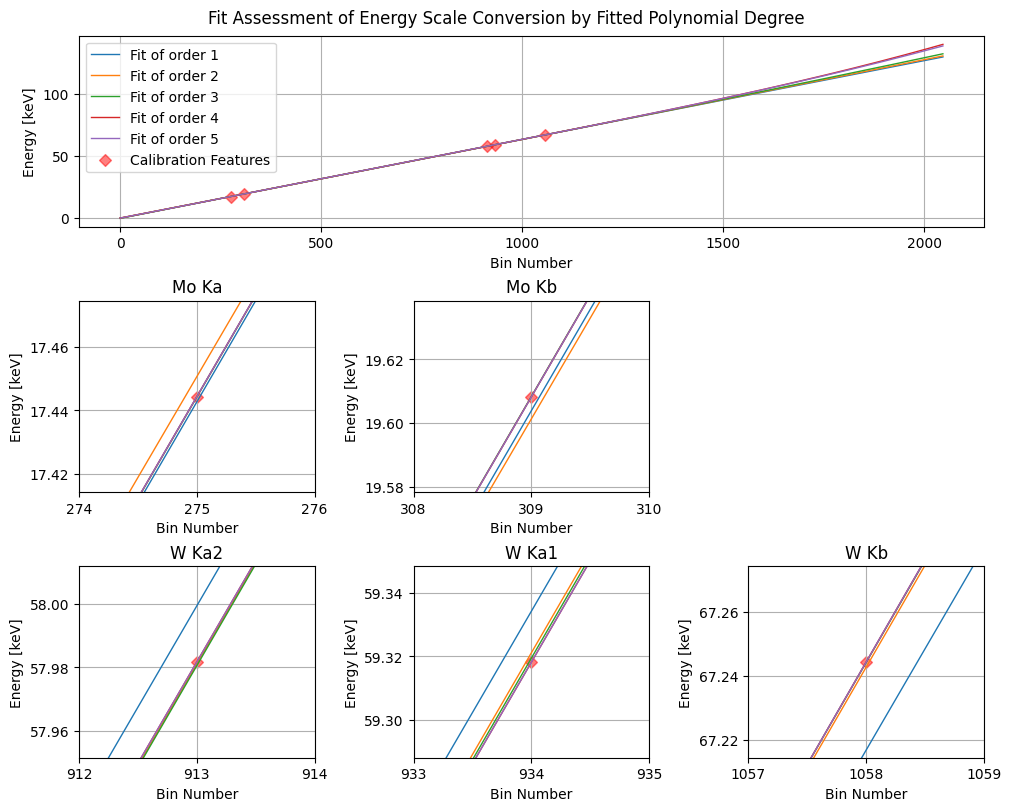

(1, 6)

In [63]:
# energy_bin_linearity((1))
energy_bin_linearity((5))

In [406]:
def energy_bin_fit(sobj):
    if type(sobj) == sample:
        cal_feat_list = ((sobj.scans[0]).get_cal_features())
        return cal_feat_list
    elif type(sobj) == scan:
        cal_feat_list = (sobj.get_cal_features())
        return cal_feat_list
    

In [366]:
energy_bin_linearity(HS602.scans[1], 2, 2)

TypeError: energy_bin_linearity() takes 1 positional argument but 3 were given

In [143]:
d = energy_bin_linearity((2,2), [])
d[2020]

4082421

In [298]:
cal_feat_list = [Mo_ka, Mo_kb, W_ka2, W_ka1, W_kb]
# cal_feat_list
# [i[0] for i in cal_feat_list]

In [145]:
type([1,2,3])

list

In [146]:
energy_bin_linearity((2))

TypeError: energy_bin_linearity() missing 1 required positional argument: 'bin_list'

In [147]:
for g in range(5):
    print (g)

0
1
2
3
4


In [148]:
class sample:
    
    recipe_ph = None
    recipe_steel = None
    
    aging_temp = None
    aging_atm = None
    aging_humidity = None
    aging_time = None
    
    def __init__(self, sample_name, scan_set):
        self.name = sample_name
        self.scans = scan_set
        self.scan_len = len(self.scans)
            
    #Set attributes of the class, the instantiation helper function should do most of this
    def set_ph(self, hi_low_string): self.recipe_ph = hi_low_string
    def set_steel_fiber(self, true_false): self.recipe_steel = true_false
    def set_temp(self, temperature): self.aging_temp = temperature
    def set_atm(self, atmosphere): self.aging_atm = atmosphere
    def set_humidity(self, rh): self.aging_humidity = rh
    def set_time(self, days): self.aging_time = days

    #Return values of each attribute or parameter
    def get_ph(self): return (self.recipe_ph)
    def get_steel_fiber(self): return (self.recipe_steel)    
    def get_temp(self): return (self.aging_temp)    
    def get_atm(self): return (self.aging_atm)
    def get_humidity(self): return (self.aging_humidity)
    def get_time(self): return (self.aging_time)
    def get_len(self): return self.scan_len 
    def get_positions(self):
        scan_pos = []
        for a in range(self.scan_len):
            if (self.scans[a]).beam_position == None:
                scan_pos.append(0)
            else:
                scan_pos.append((self.scans[a]).beam_position)
        return scan_pos
    def get_attr(self):
        line = '\n'
        name = self.name
        p = ('pH: ' + self.get_ph())
        steel = ('Contains steel fiber: ' + str(self.get_steel_fiber()))
        temp = ('Temperature: ' + str(self.get_temp()))
        atm = ('Atmosphere: ' + self.get_atm())
        time = ('Aging Time: ' + str(self.get_time()) + ' Days')
        leng = ('Number of scans in sample: ' + str(self.get_len()))
        scanpos = ('Positions of scans on sample: ' + str(self.get_positions()))
        return print(line + name + line + p + line + steel + line + temp + line + 
                     atm + line + time + line + leng + line + scanpos)
      
        
        
    #Quick plotting functions of the class:
    def quick_plot(self):
        length = self.get_len()
        x_data_bins = list(range(len((self.scans[0]).spectra)))
        fig, ax = plt.subplots()
        for g in range(length):
            ax.plot(x_data_bins, (self.scans[g]).spectra, linewidth=0.5)
        ax.set_xlabel('Bin Number')
        ax.set_ylabel('Counts')
        ax.grid(True)
        ax.set_title(str(self.name) + " EDXRD Spectra by Bins")
        return (fig, ax)
    
    def quick_plot_en(self):
        x_data_en = []
        x1 = (self.scans[0]).cal_feat_1[0]
        y1 = (self.scans[0]).cal_feat_1[1]
        x2 = (self.scans[0]).cal_feat_2[0]
        y2 = (self.scans[0]).cal_feat_2[1]
        for a in range(len((self.scans[0]).spectra)):
            lin_interp = (y2-y1)*(a-x1)/(x2-x1) + y1
            x_data_en.append(lin_interp) 
        length = self.get_len()
        fig, ax = plt.subplots()
        x_data_kev = [x / 1000 for x in x_data_en]
        for g in range(length):
            #ax.plot(x_data_en, (self.scans[g]).spectra, linewidth=0.5)
            ax.plot(x_data_kev, (self.scans[g]).spectra, linewidth=0.5)
        ax.set_xlabel('Energy [keV]')
        ax.set_ylabel('Counts')
        ax.set_title(str(self.name) + " EDXRD Spectra by keV")
        ax.grid(True)
        return (fig, ax)    
    
    def quick_stack(self):
        length = self.get_len()
        x_data_bins = list(range(len((self.scans[0]).spectra)))
        fig, ax = plt.subplots()
        for g in range(length):
            ax.plot(x_data_bins, (self.scans[g]).spectra + g*100, linewidth=0.5)
        ax.grid(True)
        return (fig, ax)
    
    def quick_integral(self, limits, index_start):
        length = self.get_len()
        x_data_bins = list(range(len((self.scans[0]).spectra)))
        integrate_peak = []
        position_array = []#self.get_positions()
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
        peak_max = 0.0
        for g in range(length):
            if g >= index_start:
                position_array.append((self.scans[g]).beam_position)
                ax1.plot(x_data_bins, (self.scans[g]).spectra, linewidth=.8, color = 'b')
                intensity = (self.scans[g]).spectra
                peak_area = 0.0
                for h in range(limits[0], limits[1]):
                    i1 = intensity[h]
                    i2 = intensity[h+1]
                    avg = (i1 + i2)/2
                    peak_area = peak_area + avg
                    if ((self.scans[g]).spectra)[h] > peak_max:
                        peak_max = ((self.scans[g]).spectra)[h]            
                integrate_peak.append(peak_area)
        ax1.set_xlim(limits[0],limits[1])
        ax1.set_ylim(0, peak_max + 50)
        ax2.plot(position_array, integrate_peak, linewidth=1)
        ax1.grid(True)
        ax2.grid(True)
        ax1.set_xlabel('Bin Number')
        ax1.set_ylabel('Counts')
        ax2.set_xlabel('Radius [mm]')
        ax2.set_ylabel('Peak Area')
        fig.suptitle(str(self.name) + " Sample's Peak and Peak Area Integral as a Function of Radius")
        fig.tight_layout()
        return (fig, (ax1, ax2))
    
    def quick_integral_en(self, limits, index_start):
        x_data_en = []
        x1 = (self.scans[0]).cal_feat_1[0]
        y1 = (self.scans[0]).cal_feat_1[1]
        x2 = (self.scans[0]).cal_feat_2[0]
        y2 = (self.scans[0]).cal_feat_2[1]
        for a in range(len((self.scans[0]).spectra)):
            lin_interp = (y2-y1)*(a-x1)/(x2-x1) + y1
            x_data_en.append(lin_interp)
        x_data_kev = [x / 1000 for x in x_data_en]

        
        lower = None
        upper = None
        
        for d in range(len(x_data_kev)):
            if x_data_kev[d]>limits[0]:
                lower = d
                break
                
        for e in range(len(x_data_kev)):
            if x_data_kev[e]>limits[1]:
                upper = e
                break
                        
        length = self.get_len()
        x_data_bins = list(range(len((self.scans[0]).spectra)))
        integrate_peak = []
        position_array = []#self.get_positions()
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
        peak_max = 0.0
        for g in range(length):
            if g >= index_start:
                position_array.append((self.scans[g]).beam_position)
                ax1.plot(x_data_kev, (self.scans[g]).spectra, linewidth=.8, color = 'b')
                intensity = (self.scans[g]).spectra
                peak_area = 0.0
                for h in range(lower, upper):
                    i1 = intensity[h]
                    i2 = intensity[h+1]
                    avg = (i1 + i2)/2
                    peak_area = peak_area + avg
                    if ((self.scans[g]).spectra)[h] > peak_max: peak_max = ((self.scans[g]).spectra)[h]            
                integrate_peak.append(peak_area)
        ax1.set_xlim(limits[0],limits[1])
        ax1.set_ylim(0, peak_max + 50)
        ax2.plot(position_array, integrate_peak, linewidth=1)
        ax1.grid(True)
        ax2.grid(True)
        ax1.set_xlabel('Energy [keV]')
        ax1.set_ylabel('Counts')
        ax2.set_xlabel('Radius [mm]')
        ax2.set_ylabel('Peak Area')
        fig.suptitle(str(self.name) + " Sample's Peak and Peak Area Integral as a Function of Radius")
        fig.tight_layout()
        return (fig, (ax1, ax2))
    
    def quick_wire(self):
        length = self.get_len()
        x_data_bins = list(range(len((self.scans[0]).spectra)))
        pos_array = self.get_positions()
        dataset = []
        for r in range(length):
            tup = self.scans[r].spectra, pos_array[r]
            dataset.append(tup)
        return dataset
    
    def stack(self, off):
        y_off = off
        length = self.get_len()
        x_data_bins = list(range(len((self.scans[0]).spectra)))
        fig, ax = plt.subplots()#(figsize=(5, 2.7), layout='constrained')
        for g in range(length):
            ax.plot(x_data_bins, (self.scans[g]).spectra + g*y_off, linewidth=0.5)
        ax.grid(True)
        return (fig, ax)

    
    
    
    #Custom Plotting methods of the class:
    def custom_stack(self, **kwargs):
        i_bound = (None, None)
        intervals = None
        y_off = 0
        x_bound = (None, None)
        y_bound = (None, None)
        units = 'Bins'
        
        for key, value in kwargs.items():
            
            #Setting the bounds of the stacked data
            if key == 'i':
                i = value
                #if i is given as a tuple:
                if type(i) == tuple:
                    if type(i[0]) == int and type(i[1]) == int:
                        if i[0] < 0 or i[1] < 0:
                            return print('Error: Int cannot be negatives')
                        elif i[0] > len(self.get_positions()) or i[1] > len(self.get_positions()):
                            return print('Error: Index out of range')
                        else:
                            if i[0] == i[1]: i_bound = (i[0], i[0])
                            if i[1] > i[0]: i_bound = (i[0], i[1])
                            else: i_bound = (i[1], i[0])
                    else: return print('Error: Expected tuple of two ints')

                #If i is given as an int:    
                elif type(i) == int:
                    if i < 1: return print('Error: i must be an int greater than 0')
                    elif i < len(self.get_positions()): i_bound = (i, None)
                    else: return print('Error: i is out of range')

                #if i is given as wrong type:
                else:
                    return print('Error: Expected i bound(s) as int or int tuple')
            
            #Interval of plotting (i.e. skip every other if interval == 2, etc.)
            elif key == 'interval':
                interval = value
                if type(interval) == int:
                    if interval > 0:
                        if interval < len(self.get_positions()): intervals = interval
                        else: return print('Error: Interval out of bounds')
                    else: return print('Error: Expected interval greater than 0')
                else: return print('Error: Expected interval as int')
            
            #Spacing between lines
            elif key == 'spacing':
                offset = value
                if type(offset) != int or offset < 1: return print('Error: Expected spacing as int greater than 0')
                else:
                    y_off = value
            
            #Xlimits of the graph
            elif key == 'xlim':
                x_range = value
                if type(x_range) == int: x_bound = (x_range, None)
                elif type(x_range) == tuple: x_bound = x_range
                else: return print('Error: Expected xlim as int or int tuple')

            #Ylimits of the graph
            elif key == 'ylim':
                y_range = value
                if type(y_range) == int: y_bound = (y_range, None)
                elif type(y_range) == tuple: y_bound = y_range
                else: return print('Error: Expected ylim as int or int tuple')            
            

        length = self.get_len()
        x_data_bins = list(range(len((self.scans[0]).spectra)))
        fig, ax = plt.subplots()#(figsize=(5, 2.7), layout='constrained')
        for g in range(length):
            ax.plot(x_data_bins, (self.scans[g]).spectra + g*y_off, linewidth=0.5)
        ax.grid(True)
        return (fig, ax)
        
        
    def plot(self):
        return
    def stackplot(self):
        return
    def plot_d(self):
        return
    def stackplot_d(self):
        return
    

In [149]:
def sample_instant_helper(df, scannum):
    scan_index = (df[df['ScanNum']==scannum].index.values)[0]
    pos_array = df['Position'][scan_index]
    spectra_set = df['Spectra'][scan_index]
    sampname = df['FullName'][scan_index]
    pH = df['pH'][scan_index]
    time = int(df['Days'][scan_index])
    temper = int(df['Temperature'][scan_index])
    atmosphere = df['Atmosphere'][scan_index]
    st_bool = df['SteelFiber'][scan_index]
    slist = []
    for q in range(len(pos_array)):
        radius = pos_array[q]
        spectra = spectra_set[q]
        slist.append(scan(spectra, radius))
    samp = sample(sampname, slist)
    samp.set_ph(pH)
    samp.set_steel_fiber(st_bool)
    samp.set_temp(temper)
    samp.set_atm(atmosphere)
    samp.set_time(time)
    return samp

In [150]:
class series:
    def __init__(self, sample_list):
        self.list = sample_list
        
    def peak_integral_en(self, limits, index_start):
        fig_list = []
        for q in range(len(self.list)):
            smpl = self.list[q]
            smpl.quick_integral_en(limits, index_start)
            
    def peak_integral_mosaic(self, limits, index_start):
        fig_list = []
        for q in range(len(self.list)):
            smpl = self.list[q]
            smpl.quick_integral_en(limits, index_start)
            

In [151]:
# t1 = sample_instant_helper(sample_df, 1104)
# t2 = sample_instant_helper(sample_df, 1105)
# t3 = sample_instant_helper(sample_df, 1106)
# t4 = sample_instant_helper(sample_df, 1107)

# series1 = series([t1,t2,t3,t4])
# series1.peak_integral_en((82,85.5),2)





Low pH SF 25C 4d
pH: Low
Contains steel fiber: True
Temperature: 25
Atmosphere: 100% CO2
Aging Time: 4 Days
Number of scans in sample: 29
Positions of scans on sample: [-13.0, -12.75, -12.5, -12.25, -12.0, -11.75, -11.5, -11.25, -11.0, -10.75, -10.5, -10.25, -10.0, -9.75, -9.5, -9.25, -9.0, -8.75, -8.5, -8.25, -8.0, -7.75, -7.5, -7.25, -7.0, -6.75, -6.5, -6.25, -6.0]


(<Figure size 1000x600 with 2 Axes>,
 (<AxesSubplot: xlabel='Bin Number', ylabel='Counts'>,
  <AxesSubplot: xlabel='Radius [mm]', ylabel='Peak Area'>))

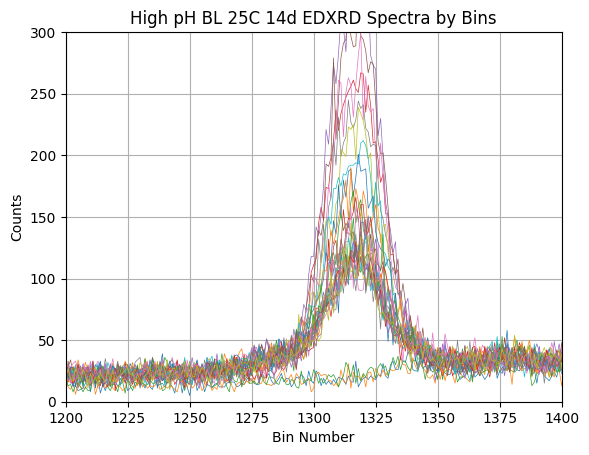

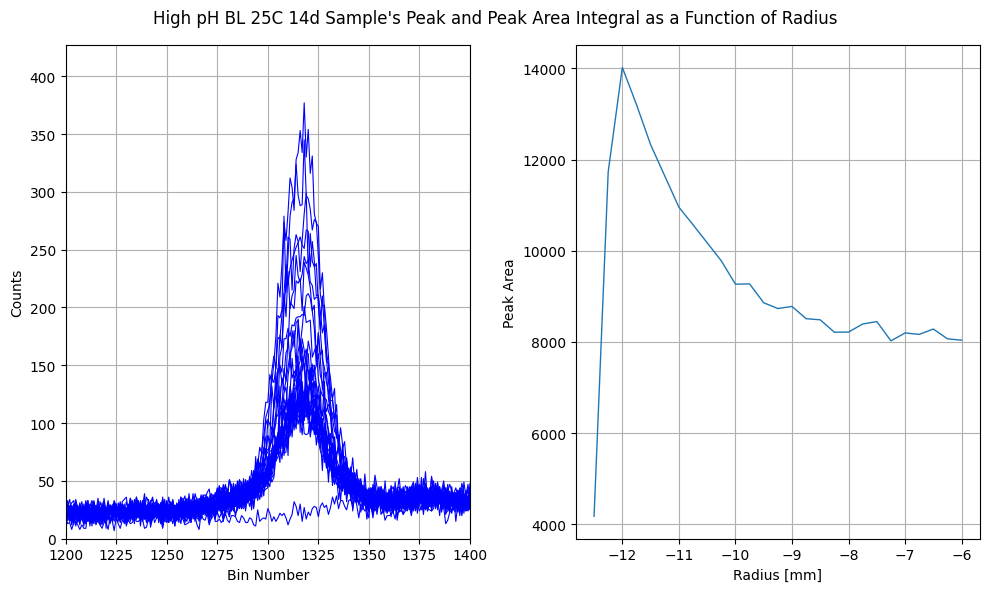

In [152]:
HS602 = sample_instant_helper(sample_df, 1091)
HS604 = sample_instant_helper(sample_df, 1092)
HS606 = sample_instant_helper(sample_df, 1083)
HS6014= sample_instant_helper(sample_df, 1087)

HS250 = sample_instant_helper(sample_df, 1093)
HS254 = sample_instant_helper(sample_df, 1094)
HS256 = sample_instant_helper(sample_df, 1089)
HS259 = sample_instant_helper(sample_df, 1088)

HB602 = sample_instant_helper(sample_df, 1105)
HB604 = sample_instant_helper(sample_df, 1104)
HB606 = sample_instant_helper(sample_df, 1103)

HB250 = sample_instant_helper(sample_df, 1108)
HB254 = sample_instant_helper(sample_df, 1107)
HB2514= sample_instant_helper(sample_df, 1106)

LS602 = sample_instant_helper(sample_df, 1096)
LS604 = sample_instant_helper(sample_df, 1095)

LS250 = sample_instant_helper(sample_df, 1102)
LS252 = sample_instant_helper(sample_df, 1101)
LS254 = sample_instant_helper(sample_df, 1100)
LS256 = sample_instant_helper(sample_df, 1097)
LS259 = sample_instant_helper(sample_df, 1098)
LS2514= sample_instant_helper(sample_df, 1099)

high_base_60 = series([HB602,HB604,HB606])
high_steel_60 = series([HS602,HS604,HS606,HS6014])
high_base_25 = series([HB250, HB254, HB2514])
high_steel_25 = series([HS250,HS254,HS256,HS259])

low_steel_60 = series([LS602, LS604])
low_steel_25 = series([LS250, LS252, LS254, LS256, LS259, LS2514])

calc_scan = scan_instant_helper(sample_df, 1071, 0, False)
calcite = sample('Calcite (CaCO3) Reference', [calc_scan]) 

LS254.get_attr()

a = HB2514.quick_plot()
a[1].set_xlim(1200,1400)
a[1].set_ylim(0,300)

HB2514.quick_integral((1200,1400),2)

In [173]:
h = calc_scan.quick_plot(True)

AttributeError: 'scan' object has no attribute 'cal_feat_1'

In [180]:
HS602.scans[1].get_cal_features()

[(275, 17444.3),
 (309, 19608.3),
 (913, 57981.7),
 (934, 59318.24),
 (1058, 67244.3)]

In [ ]:
calc_fig = calcite.quick_plot_en()
# calc_fig[1].set_xlim(60, 110)
calc_fig[1].set_ylim(0, 300)

In [ ]:
rng = (82,85.2)
high_steel_25.peak_integral_en(rng,4)
high_steel_60.peak_integral_en(rng,4)
# a = high_base_25.peak_integral_en((0,120),4)
# a[1].set_xlim(20,120)
# a[1].set_ylim(0,300)
# high_base_60.peak_integral_en(rng,4)

# bnd = (82.5,85)
# low_steel_25.peak_integral_en(bnd,0)
# low_steel_60.peak_integral_en(bnd,0)

AttributeError: 'scan' object has no attribute 'cal_feat_1'

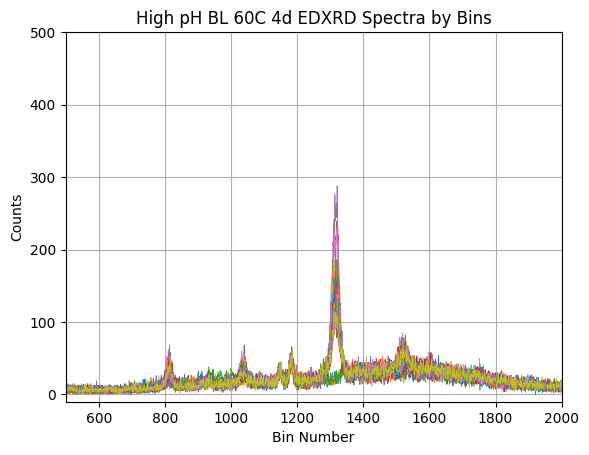

In [174]:
test = sample_instant_helper(sample_df, 1104)
h = test.quick_plot()
h[1].set_xlim(500, 2000)
h[1].set_ylim(-10, 500)
e = test.quick_plot_en()
e[1].set_xlim(40, 110)
e[1].set_ylim(-10, 500)

d = test.quick_integral_en((82,85.2),4)
# e = test.quick_integral((1280,1350),4)

In [ ]:
# sample_df

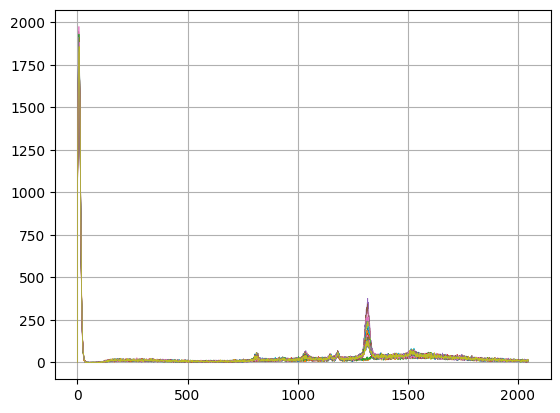

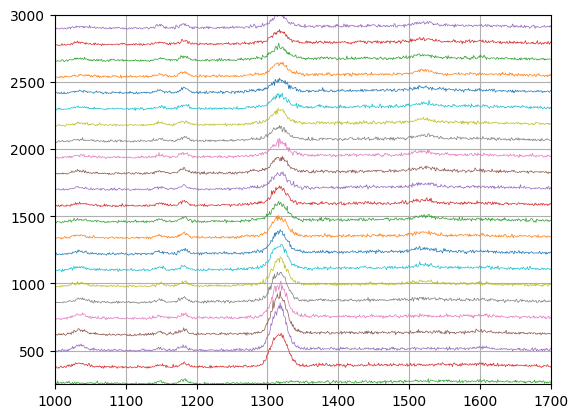

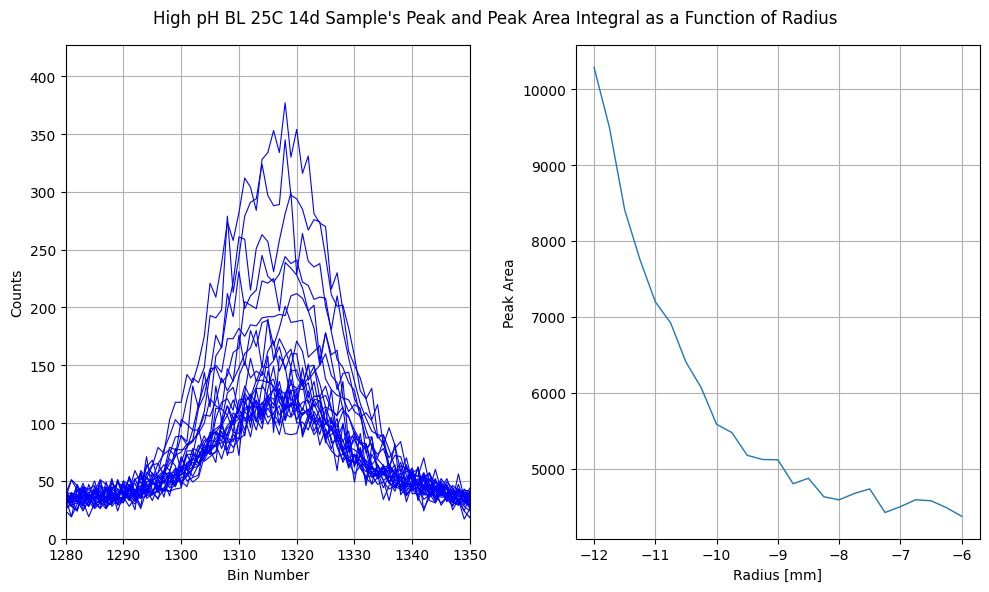

In [143]:
s1 = HB2514.custom_stack(i = (28), interval = 10, xlim = (10.5, 7.20))
stackp = HB2514.stack(120)
stackp[1].set_xlim(1000, 1700)
stackp[1].set_ylim(250, 3000)
b = HB2514.quick_integral((1280, 1350), 4)

In [ ]:
Mo_W = scan_instant_helper(sample_df, 1069, 0, False)
calcite = scan_instant_helper(sample_df, 1071, 0, True)

t = sample('Please work you stupid bastard', [Mo_W, calcite])

print(t.name)


In [ ]:
def sample_instant_helper(df, scannum):
    errorflag = True
    scan_obj_list = []

In [ ]:
Mo_W_cal = scan_instant_helper(sample_df, 1069, 0, False)
calcite_ref = scan_instant_helper(sample_df, 1071, 0, True)

Mo_W_cal.spectras

# Mo_W_cal.quick_plot()
# Mo_W_cal.quick_scatter1()